In [1]:
%load_ext autoreload
%autoreload 2

## Setup

In [3]:
from collections.abc import Callable
import pandas as pd
import seaborn as sns
import math

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer
from datasets import Dataset, load_dataset
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
from typing import Optional, Tuple
from jaxtyping import Float
from abc import ABC, abstractmethod
from dataclasses import dataclass
from random import choice, shuffle
from typing import final, cast
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
import random
import gc
from sklearn.feature_selection import mutual_info_regression


from teren.utils import get_device_str, setup_determinism

In [32]:
def clean_cache():
    torch.cuda.empty_cache()
    gc.collect()


# Utils
def generate_prompt(dataset, n_ctx: int = 1, batch: int = 1) -> torch.Tensor:
    """Generate a prompt from the dataset."""
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)
    return next(iter(dataloader))["input_ids"][:, :n_ctx]


def compute_kl_div(logits_ref: torch.Tensor, logits_pert: torch.Tensor) -> torch.Tensor:
    """Compute the KL divergence between the reference and perturbed logprobs."""
    logprobs_ref = F.log_softmax(logits_ref, dim=-1)
    logprobs_pert = F.log_softmax(logits_pert, dim=-1)
    temp_output = F.kl_div(
        logprobs_pert, logprobs_ref, log_target=True, reduction="none"
    )
    return temp_output.sum(dim=-1)


def get_random_activation(
    model: HookedTransformer, dataset: Dataset, n_ctx: int, layer: str, pos
) -> torch.Tensor:
    """Get a random activation from the dataset."""
    rand_prompt = generate_prompt(dataset, n_ctx=n_ctx)
    _, cache = model.run_with_cache(rand_prompt)
    return cache[layer][:, pos, :].to("cpu").detach()


def load_pretokenized_dataset(
    path: str,
    split: str,
) -> Dataset:
    dataset = load_dataset(path, split=split)
    dataset = cast(Dataset, dataset)
    return dataset.with_format("torch")


# Some experiment specific utils for converting a cov matrix
# to positive definite (we suspect it's because of smaller
# batch size) needed for MultivariateNormal
def is_positive_definite(A):
    try:
        torch.linalg.cholesky(A)
        return True
    except RuntimeError:
        return False


def nearest_positive_definite(A):
    B = (A + A.T) / 2
    _, s, V = torch.svd(B)
    H = V.mm(torch.diag(s).mm(V.T))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    if is_positive_definite(A3):
        return A3
    spacing = np.geomspace(torch.finfo(A.dtype).eps, 1, 10)
    for i in range(len(spacing)):
        mineig = torch.min(torch.real(torch.linalg.eigvals(A3)))
        A3 += torch.eye(A.shape[0]) * (-mineig * (1 + spacing[i]))
        if is_positive_definite(A3):
            return A3
    return A3

In [5]:
@dataclass
class ExperimentConfig:
    n_ctx: int
    perturbation_layer: str
    read_layer: str
    perturbation_pos: slice
    n_steps: int
    perturbation_range: Tuple[float, float]
    seed: Optional[int] = None
    dataloader_batch_size: Optional[int] = None
    mean_batch_size: Optional[int] = None


class Reference:
    def __init__(
        self,
        model: HookedTransformer,
        prompt: torch.Tensor,
        perturbation_layer: str,
        read_layer: str,
        perturbation_pos: slice,
        n_ctx: int,
    ):
        self.model = model
        _, n_ctx_prompt = prompt.shape
        assert (
            n_ctx == n_ctx_prompt
        ), f"n_ctx {n_ctx} must match prompt n_ctx {n_ctx_prompt}"
        self.prompt = prompt
        logits, cache = model.run_with_cache(prompt)
        self.logits = logits.to("cpu").detach()
        self.cache = cache.to("cpu")
        self.act = self.cache[perturbation_layer][:, perturbation_pos]
        self.perturbation_layer = perturbation_layer
        self.read_layer = read_layer
        self.perturbation_pos = perturbation_pos
        self.n_ctx = n_ctx

In [40]:
@dataclass(kw_only=True)
class Perturbation(ABC):
    @final
    def __call__(
        self, resid_acts: Float[torch.Tensor, "... n_ctx d_model"]
    ) -> Float[torch.Tensor, "... n_ctx d_model"]:
        """Ensures that all generate method has correct signature with beartype"""
        return self.generate(resid_acts)

    @abstractmethod
    def generate(self, resid_acts: Float[torch.Tensor, "... n_ctx d_model"]):
        raise NotImplementedError


@dataclass
class NaiveRandomPerturbation(Perturbation):
    """Isotropic random"""

    def generate(self, resid_acts):
        return torch.randn(resid_acts.shape)


@dataclass
class RandomPerturbation(Perturbation):
    """Scaled random"""

    def __init__(self, data_mean, data_cov):
        self.distrib = MultivariateNormal(data_mean.squeeze(0), data_cov)

    def generate(self, resid_acts):
        target = self.distrib.sample(resid_acts.shape[:-1])
        return target - resid_acts


@dataclass
class RandomActivationPerturbation(Perturbation):
    """Random activation direction"""

    def __init__(self, base_ref, dataset):
        self.base_ref = base_ref
        self.dataset = dataset

    def generate(self, resid_acts):
        target = get_random_activation(
            self.base_ref.model,
            self.dataset,
            self.base_ref.n_ctx,
            self.base_ref.perturbation_layer,
            self.base_ref.perturbation_pos,
        )
        return target - resid_acts


@dataclass
class SAEFeatureAblationPerturbation(Perturbation):
    def __init__(self, base_ref, sae):
        self.base_ref = base_ref
        self.sae = sae

    def generate(self, resid_acts):
        feature_acts = self.sae.encode(self.base_ref.act.squeeze())
        ablate_feature_id = torch.argmax(feature_acts)
        feature_acts[ablate_feature_id] = 0
        perturbed_act = self.sae.decode(feature_acts)
        return perturbed_act - resid_acts


@dataclass
class SAEFeaturesAblationPerturbation(Perturbation):
    def __init__(self, base_ref, sae, ablate_feature_ids):
        self.base_ref = base_ref
        self.sae = sae
        self.ablate_feature_ids = ablate_feature_ids

    def generate(self, resid_acts):
        feature_acts = self.sae.encode(self.base_ref.act.squeeze())
        feature_acts[self.ablate_feature_ids] = 0
        perturbed_act = self.sae.decode(feature_acts)
        return perturbed_act - resid_acts


@dataclass
class ControlledActivationPerturbation(Perturbation):
    def __init__(self, base_ref, prompt):
        self.base_ref = base_ref
        self.prompt = prompt

    def generate(self, resid_acts):
        model = self.base_ref.model
        pos = self.base_ref.perturbation_pos
        layer = self.base_ref.perturbation_layer

        controlled_prompt = torch.tensor([model.tokenizer.encode(self.prompt)])
        _, cache = self.base_ref.model.run_with_cache(controlled_prompt)

        target = cache[layer][:, pos, :].to("cpu").detach()
        return target - resid_acts


@dataclass
class RandomSensitiveDirectionPerturbation(Perturbation):
    def __init__(self, base_ref, dataset, sae, top_k=3):
        self.base_ref = base_ref
        self.dataset = dataset
        self.sae = sae
        self.top_k = top_k

    def get_top_features_ablated_direction(self, acts):
        feature_acts = self.sae.encode(acts)
        active_feature_ids = (feature_acts > 0).nonzero().squeeze()
        sorted_indices = torch.argsort(
            feature_acts[active_feature_ids], descending=True
        )
        sorted_active_feature_ids = active_feature_ids[sorted_indices]
        to_ablate_feature_ids = sorted_active_feature_ids[: self.top_k]
        feature_acts[to_ablate_feature_ids] = 0
        perturbed_act = self.sae.decode(feature_acts)
        return perturbed_act

    def get_top_features_direction(self, acts):
        feature_acts = self.sae.encode(acts)
        active_feature_ids = (feature_acts > 0).nonzero().squeeze()
        sorted_indices = torch.argsort(
            feature_acts[active_feature_ids], descending=True
        )
        sorted_active_feature_ids = active_feature_ids[sorted_indices]
        to_ablate_feature_ids = sorted_active_feature_ids[self.top_k :]
        feature_acts[to_ablate_feature_ids] = 0
        perturbed_act = self.sae.decode(feature_acts)
        return perturbed_act

    def generate(self, resid_acts):
        ablated_acts = self.get_top_features_ablated_direction(resid_acts.squeeze())
        target_acts = get_random_activation(
            self.base_ref.model,
            self.dataset,
            self.base_ref.n_ctx,
            self.base_ref.perturbation_layer,
            self.base_ref.perturbation_pos,
        )
        target_acts = self.get_top_features_direction(target_acts.squeeze())
        return ablated_acts - resid_acts + target_acts

In [186]:
def run_perturbed_activation(
    base_ref: Reference,
    perturbed_activations: Float[torch.Tensor, "... n_steps 1 d_model"],
):
    def hook(act, hook):
        act[:, base_ref.perturbation_pos, :] = perturbed_activations

    with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
        prompts = torch.cat(
            [base_ref.prompt for _ in range(len(perturbed_activations))]
        )
        logits_pert, cache = base_ref.model.run_with_cache(prompts)

    return logits_pert.to("cpu").detach(), cache.to("cpu")


def compare(
    base_ref: Reference,
    perturbed_activations: Float[torch.Tensor, "... n_steps 1 d_model"],
) -> Float[torch.Tensor, "n_steps"]:
    logits_pert, _ = run_perturbed_activation(base_ref, perturbed_activations)
    kl_div = compute_kl_div(base_ref.logits, logits_pert)[
        :, base_ref.perturbation_pos
    ].squeeze(-1)
    return kl_div


def scan(
    perturbation: Perturbation,
    activations: Float[torch.Tensor, "... n_ctx d_model"],
    n_steps: int,
    range: tuple[float, float],
) -> Float[torch.Tensor, "... n_steps 1 d_model"]:
    direction = perturbation(activations)
    direction -= torch.mean(direction, dim=-1, keepdim=True)

    act_norm = torch.linalg.vector_norm(activations, dim=-1, keepdim=True)
    dir_norm = torch.linalg.vector_norm(direction, dim=-1, keepdim=True)
    scale = act_norm / dir_norm
    direction *= scale

    perturbed_steps = [
        activations + alpha * direction for alpha in torch.linspace(*range, n_steps)
    ]
    perturbed_activations = torch.cat(perturbed_steps, dim=0)
    return perturbed_activations


def run_perturbation(
    cfg: ExperimentConfig, base_ref: Reference, perturbation: Perturbation
):
    perturbed_activations = scan(
        perturbation=perturbation,
        activations=base_ref.act,
        n_steps=cfg.n_steps,
        range=cfg.perturbation_range,
    )
    kl_div = compare(base_ref, perturbed_activations)
    return kl_div, perturbed_activations.squeeze(dim=1)

In [18]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=6,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0, 1),
    n_steps=100,
    mean_batch_size=512,
)

In [19]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


# setup_determinism(cfg.seed)
set_seed(cfg.seed)

In [20]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [21]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [22]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
sparsity = sparsities[cfg.perturbation_layer].cpu()

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


## Choosing prompt

In [31]:
# generate random prompt
# base_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
# base_prompt_text = model.tokenizer.batch_decode(base_prompt)
# print(base_prompt_text)

base_prompt = torch.tensor([[3513, 553, 262, 8009, 531, 13, 198, 198, 1858, 547]])
print(model.tokenizer.decode(base_prompt[0]))

base_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    base_prompt.shape[1],
)

 treatment," the announcement said.

There were


## Running perturbations (naive random, random, r-other, so on)

In [33]:
batch_of_prompts = generate_prompt(dataset, n_ctx=cfg.n_ctx, batch=cfg.mean_batch_size)
batch_act_cache = model.run_with_cache(batch_of_prompts)[1].to("cpu")
data = batch_act_cache[cfg.perturbation_layer][:, cfg.perturbation_pos, :].squeeze(1)

print(data.shape)

data_mean = data.mean(dim=0, keepdim=True)
data_cov = (
    torch.einsum("i j, i k -> j k", data - data_mean, data - data_mean) / data.shape[0]
)

torch.Size([512, 768])


In [34]:
# substitute covariance matrix with nearest that is positive definite
if not is_positive_definite(data_cov):
    print("cov matrix is not positive definite, tweaking..")
    data_cov = nearest_positive_definite(data_cov)

cov matrix is not positive definite, tweaking..


In [187]:
naive_random_perturbation = NaiveRandomPerturbation()
random_perturbation = RandomPerturbation(data_mean, data_cov)
random_activation_perturbation = RandomActivationPerturbation(base_ref, dataset)

random_sensitivite_direction_perturbation = RandomSensitiveDirectionPerturbation(
    base_ref, dataset, sae
)

perturbations = {
    "naive random": naive_random_perturbation,
    "random": random_perturbation,
    "random other activation": random_activation_perturbation,
    # "sensitive random": random_sensitivite_direction_perturbation
}

In [188]:
results = defaultdict(list)
results_step_activations = defaultdict(list)

for _ in tqdm(range(10)):
    for name, perturbation in perturbations.items():
        kl_div, perturbed_steps = run_perturbation(cfg, base_ref, perturbation)
        results[name].append(kl_div)
        results_step_activations[name].append(perturbed_steps)

100%|██████████| 10/10 [00:19<00:00,  1.90s/it]


In [192]:
# ------------ Controlled prompt perturbation ------------
controlled_other_prompt_tokens = torch.tensor(
    [[447, 250, 464, 12601, 329, 530, 284, 1115, 11826, 373]]
)
controlled_other_prompt = model.tokenizer.decode(controlled_other_prompt_tokens[0])
controlled_activation_perturbation = ControlledActivationPerturbation(
    base_ref, controlled_other_prompt
)

perturb_name = "controlled other activation"
kl_div_co, perturbed_steps_co = run_perturbation(
    cfg, base_ref, controlled_activation_perturbation
)
results[perturb_name] = [kl_div_co]
results_step_activations[perturb_name] = [perturbed_steps_co]

# ------------ Ablating top feature ------------
perturb_name = "sae top feature ablation"
sae_top_feature_ablation_perturbation = SAEFeatureAblationPerturbation(base_ref, sae)
kl_div_fa, perturbed_steps_fa = run_perturbation(
    cfg, base_ref, sae_top_feature_ablation_perturbation
)
results[perturb_name] = [kl_div_fa]
results_step_activations[perturb_name] = [perturbed_steps_fa]


# ------------ Ablating optimal top features ------------
# Pareto optimal features (largest KL div)
ablate_feature_ids = [16620, 1168]
sae_pareto_features_ablation_perturbation = SAEFeaturesAblationPerturbation(
    base_ref, sae, ablate_feature_ids
)
perturb_name = "sae pareto features ablation"
kl_div_pfa, perturbed_steps_pfa = run_perturbation(
    cfg, base_ref, sae_pareto_features_ablation_perturbation
)

results[perturb_name] = [kl_div_pfa]
results_step_activations[perturb_name] = [perturbed_steps_pfa]

In [194]:
def find_active_features():
    # Feature activations and feature IDs
    acts = base_ref.act.squeeze()
    feature_acts = sae.encode(acts)
    active_feature_ids = (feature_acts > 0).nonzero().squeeze()

    active_features_with_acts = {}

    for i, (f_id, f_act) in enumerate(
        sorted(
            zip(active_feature_ids, feature_acts[active_feature_ids]),
            key=lambda t: t[1],
            reverse=True,
        )
    ):
        print(f"{i} {f_id} - {f_act.item():.4f}")
        active_features_with_acts[f_id.item()] = round(f_act.item(), 4)
    return active_features_with_acts


active_features_with_acts = find_active_features()

0 18988 - 13.6872
1 16620 - 13.6526
2 19223 - 4.6340
3 19660 - 4.0049
4 15017 - 1.8477
5 17359 - 1.5700
6 1168 - 1.1308
7 6689 - 1.1284
8 344 - 0.7752
9 7137 - 0.4669
10 4581 - 0.3041
11 19029 - 0.2826
12 2065 - 0.2736
13 8614 - 0.1686
14 2505 - 0.1355
15 3626 - 0.1093
16 10115 - 0.0458


In [195]:
# Interpolate between features in each activation
def feature_interpolation_random_activation(base_ref, dataset, sae):
    acts = base_ref.act.squeeze()
    feature_acts = sae.encode(acts)
    active_feature_ids = (feature_acts > 0).nonzero().squeeze()

    target_acts = get_random_activation(
        base_ref.model,
        dataset,
        base_ref.n_ctx,
        base_ref.perturbation_layer,
        base_ref.perturbation_pos,
    )

    target_act_sae = sae.decode(sae.encode(target_acts.squeeze()))

    target_feature_acts = sae.encode(target_acts.squeeze())
    target_active_feature_ids = (target_feature_acts > 0).nonzero().squeeze()

    active_feature_ids = set(active_feature_ids.tolist())
    target_active_feature_ids = set(target_active_feature_ids.tolist())

    all_active_feature_ids = list(
        set(active_feature_ids | set(target_active_feature_ids))
    )

    step_sizes = {}

    all_feature_acts = feature_acts[all_active_feature_ids].tolist()
    all_target_feature_acts = target_feature_acts[all_active_feature_ids].tolist()

    for idx, (s, e) in enumerate(zip(all_feature_acts, all_target_feature_acts)):
        step_size = (e - s) / cfg.n_steps
        step_sizes[all_active_feature_ids[idx]] = step_size

    perturbed_activations = []

    for _ in range(cfg.n_steps):
        for f_id, step_size in step_sizes.items():
            feature_acts[f_id] += step_size

        perturbed_act = sae.decode(feature_acts)
        perturbed_activations.append(perturbed_act.unsqueeze(dim=0).unsqueeze(dim=0))

    assert torch.allclose(
        target_act_sae.squeeze(), perturbed_activations[-1].squeeze(), atol=1e-4
    )

    perturbed_activations = torch.cat(perturbed_activations, dim=0)
    kl_divs = compare(base_ref, perturbed_activations)

    scale = torch.linalg.vector_norm(target_act_sae) / torch.linalg.vector_norm(
        target_act_sae - acts
    )

    return kl_divs, scale.item()


# kl_divs, scale = feature_interpolation_random_activation(base_ref, dataset, sae)
# results["feature interpolation"] = [kl_divs]

In [ ]:
# clean_cache()

In [196]:
def plot_results(results):
    colors = {
        "random": "tab:blue",
        "naive random": "tab:purple",
        "random other activation": "tab:orange",
        "controlled other activation": "tab:cyan",
        "sae top feature ablation": "tab:red",
        "sae pareto features ablation": "xkcd:green",
        "sensitive random": "tab:purple",
        "feature interpolation": "tab:pink",
    }

    properties = {
        "sae top feature ablation": {"linewidth": 1, "linestyle": "--"},
        "sae pareto features ablation": {"linewidth": 1, "linestyle": "--"},
        "feature interpolation": {"linewidth": 1, "linestyle": "--"},
        "controlled other activation": {"linewidth": 1, "linestyle": "--"},
    }

    for name in results.keys():
        for i, data in enumerate(results[name]):
            linewdith = properties.get(name, {}).get("linewidth", 0.5)
            linestyle = properties.get(name, {}).get("linestyle", "-")

            if i == 0:
                # Only label the first line for each perturb_name
                plt.plot(
                    data,
                    color=colors[name],
                    label=name,
                    linewidth=linewdith,
                    linestyle=linestyle,
                )
            else:
                # Don't label subsequent lines to avoid duplicate legend entries
                plt.plot(
                    data, color=colors[name], linewidth=linewdith, linestyle=linestyle
                )

    plt.legend(fontsize=8, loc="upper left")
    plt.ylabel("KL divergence to base logits")
    plt.xlabel(f"Distance from base activation at {cfg.read_layer}")
    plt.show()

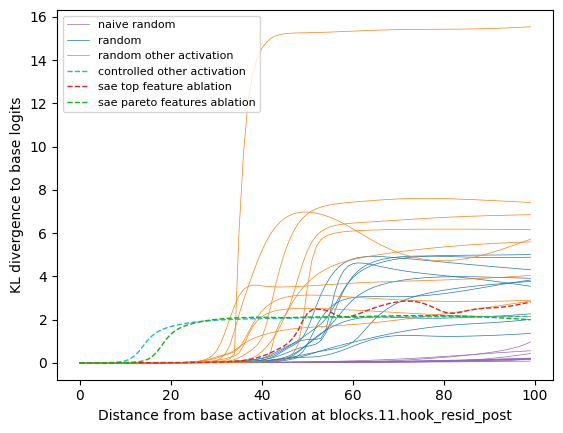

In [197]:
plot_results(results)

## Finding sensitive features

In [76]:
from itertools import combinations


def generate_ablation_combinations(feature_ids):
    all_combinations = []
    for r in range(1, len(feature_ids) + 1):
        all_combinations.extend(combinations(feature_ids, r))
    return all_combinations


def generate_ablation_combinations_of_triplets(feature_ids):
    return list(combinations(feature_ids, 3))

In [77]:
base_act = base_ref.act.squeeze()
feature_acts = sae.encode(base_act)

print(base_act.norm())

non_negative_features = (feature_acts > 0).nonzero().squeeze()
if isinstance(non_negative_features, int):
    non_negative_features = torch.tensor([non_negative_features])

# Get base logits
logits_base, _ = model.run_with_cache(base_ref.prompt)
logprobs_base = F.log_softmax(logits_base[:, -1, :], dim=-1)

desc_sorted_indices = torch.argsort(
    feature_acts[non_negative_features], descending=True
)
sorted_feature_ids_desc = non_negative_features[desc_sorted_indices]

print(sorted_feature_ids_desc)
print([round(n, 4) for n in feature_acts[sorted_feature_ids_desc].numpy()])

tensor(54.9912)
tensor([18988, 16620, 19223, 19660, 15017, 17359,  1168,  6689,   344,  7137,
         4581, 19029,  2065,  8614,  2505,  3626, 10115])
[13.6872, 13.6526, 4.634, 4.0049, 1.8477, 1.57, 1.1308, 1.1284, 0.7752, 0.4669, 0.3041, 0.2826, 0.2736, 0.1686, 0.1355, 0.1093, 0.0458]


In [ ]:
# plt.hist(F.softmax(feature_acts[sorted_feature_ids_desc], dim=-1))
# plt.show()

In [78]:
print(len(sorted_feature_ids_desc))

skip = 0
n_features = 9
feature_ids_to_ablate = [
    f_id.item() for f_id in sorted_feature_ids_desc[skip : skip + n_features]
]
print(feature_ids_to_ablate)
print(len(feature_ids_to_ablate), 2**n_features)

17
[18988, 16620, 19223, 19660, 15017, 17359, 1168, 6689, 344]
9 512


In [79]:
ablation_results = []

all_combinations = generate_ablation_combinations(feature_ids_to_ablate)
# all_combinations = generate_ablation_combinations_of_triplets(feature_ids_to_ablate)
l2_act = base_act.norm()

for i, feature_ids in enumerate(all_combinations):
    if i % 250 == 0:
        print(f"Step {i}/{len(all_combinations)}")

    step_feature_acts = feature_acts.clone()
    step_feature_acts[list(feature_ids)] = 0
    perturbed_act = sae.decode(step_feature_acts)

    def hook(act, hook):
        act[:, -1, :] = perturbed_act

    with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
        logits_pert, _ = model.run_with_cache(base_ref.prompt)

    logprobs_pert = F.log_softmax(logits_pert[:, -1, :], dim=-1)
    kl_div = F.kl_div(
        logprobs_pert, logprobs_base, log_target=True, reduction="batchmean"
    )
    l2_pert = torch.norm(base_act - perturbed_act)

    ablation_results.append(
        {
            "feature_ids": feature_ids,
            "n_features": len(feature_ids),
            "kl_div": kl_div.item(),
            "l2": l2_pert.item(),
            "L2(P) / L2(A)": l2_pert.item() / l2_act.item(),
            "perturbed_act": perturbed_act,
        }
    )

Step 0/511
Step 250/511
Step 500/511


In [80]:
abl_df = pd.DataFrame(ablation_results)
# comb_df.kl_div.describe()
# abl_df.head()

In [81]:
abl_df.sort_values(by="kl_div", ascending=False).head()

,feature_ids,n_features,kl_div,l2,L2(P) / L2(A),perturbed_act
510,"(18988, 16620, 19223, 19660, 15017, 17359, 116...",9,7.980583,31.065876,0.564925,"[tensor(0.2519), tensor(-0.0602), tensor(-0.19..."
503,"(18988, 16620, 19223, 19660, 15017, 17359, 668...",8,7.499382,30.594278,0.556349,"[tensor(0.3189), tensor(-0.0783), tensor(-0.25..."
502,"(18988, 16620, 19223, 19660, 15017, 17359, 116...",8,7.434280,30.882452,0.561589,"[tensor(0.2109), tensor(-0.0798), tensor(-0.07..."
501,"(18988, 16620, 19223, 19660, 15017, 17359, 116...",8,7.415069,30.650320,0.557368,"[tensor(0.2214), tensor(-0.0401), tensor(-0.20..."
504,"(18988, 16620, 19223, 19660, 15017, 1168, 6689...",8,7.405752,30.189987,0.548997,"[tensor(0.2249), tensor(-0.0567), tensor(-0.22..."


In [82]:
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient


lp_values = abl_df["L2(P) / L2(A)"]  # Your L(P) values
kl_div_values = abl_df.kl_div  # Your KL divergence values
costs = np.column_stack((lp_values, -kl_div_values))
pareto_points = is_pareto_efficient(costs)

abl_df["is_pareto_efficient"] = pareto_points
abl_df["diff_from_max"] = abl_df.kl_div.apply(lambda kl: kl - abl_df.kl_div.max())
abl_df["ratio"] = abl_df.kl_div / abl_df["L2(P) / L2(A)"]

In [83]:
pareto_df = abl_df[abl_df.is_pareto_efficient].sort_values(by="kl_div", ascending=False)
ablate_feature_ids = list(pareto_df.iloc[0].feature_ids)
ablate_feature_ids

[18988, 16620, 19223, 19660, 15017, 17359, 1168, 6689, 344]

In [142]:
pareto_df[pareto_df.kl_div > 1].sort_values(by="L2(P) / L2(A)", ascending=True).head(10)

,feature_ids,n_features,kl_div,l2,L2(P) / L2(A),perturbed_act,is_pareto_efficient,diff_from_max,ratio
1,"(16620,)",1,1.895489,14.852369,0.270086,"[tensor(-0.6215), tensor(0.2706), tensor(0.163...",True,-6.085094,7.018086
23,"(16620, 344)",2,1.904688,14.928280,0.271467,"[tensor(-0.5910), tensor(0.2505), tensor(0.173...",True,-6.075895,7.016285
20,"(16620, 17359)",2,1.908561,15.018841,0.273114,"[tensor(-0.5945), tensor(0.2671), tensor(0.191...",True,-6.072023,6.988158
21,"(16620, 1168)",2,1.920035,15.031259,0.273339,"[tensor(-0.6885), tensor(0.2887), tensor(0.220...",True,-6.060548,7.024364
92,"(16620, 1168, 344)",3,1.928912,15.130524,0.275144,"[tensor(-0.6581), tensor(0.2686), tensor(0.230...",True,-6.051671,7.010543
88,"(16620, 17359, 1168)",3,1.933368,15.219266,0.276758,"[tensor(-0.6616), tensor(0.2852), tensor(0.248...",True,-6.047215,6.985766
85,"(16620, 15017, 1168)",3,1.940425,15.288819,0.278023,"[tensor(-0.6920), tensor(0.2400), tensor(0.207...",True,-6.040159,6.979366
217,"(16620, 17359, 1168, 344)",4,1.941839,15.351710,0.279167,"[tensor(-0.6311), tensor(0.2651), tensor(0.258...",True,-6.038744,6.955841
213,"(16620, 15017, 1168, 6689)",4,1.943332,15.428606,0.280565,"[tensor(-0.6509), tensor(0.2596), tensor(0.086...",True,-6.037251,6.926494
214,"(16620, 15017, 1168, 344)",4,1.948995,15.444081,0.280846,"[tensor(-0.6615), tensor(0.2199), tensor(0.216...",True,-6.031588,6.939717


In [163]:
# feature1_act = pareto_df[pareto_df.feature_ids == (16620,)].perturbed_act.iloc[0]
# feature2_act = pareto_df[pareto_df.feature_ids == (18988,)].perturbed_act.iloc[0]

# torch.cosine_similarity(feature1_act, feature2_act, dim=0)
# torch.cosine_similarity(feature1_act, base_act, dim=0)
# torch.cosine_similarity(feature2_act, base_act, dim=0)
# torch.cosine_similarity(sae.W_dec[16620], sae.W_dec[18988], dim=0)

In [ ]:
# # Create the violin plot
# plt.figure(figsize=(12, 6))
# sns.violinplot(x='n_features', y='kl_div', data=comb_df)

# # Customize the plot
# plt.title('Distribution of KL Divergence by Number of Features')
# plt.xlabel('Number of Features')
# plt.ylabel('KL Divergence')

# # Show the plot
# plt.show()

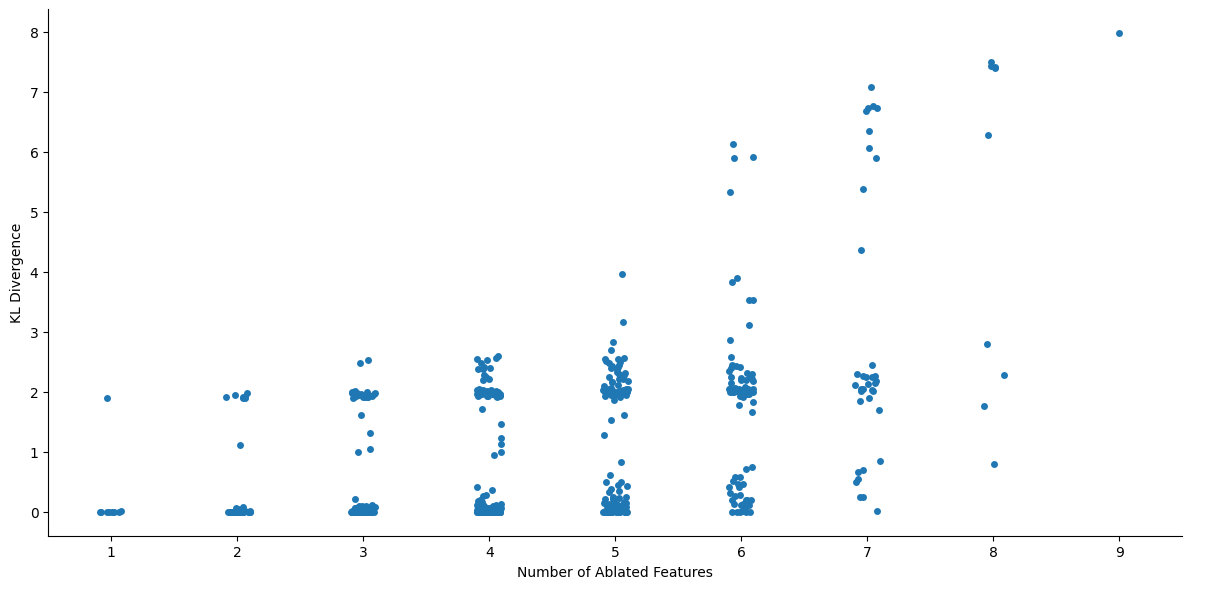

In [85]:
sns.catplot(x="n_features", y="kl_div", data=abl_df, kind="strip", height=6, aspect=2)
plt.xlabel("Number of Ablated Features")
plt.ylabel("KL Divergence")
plt.show()

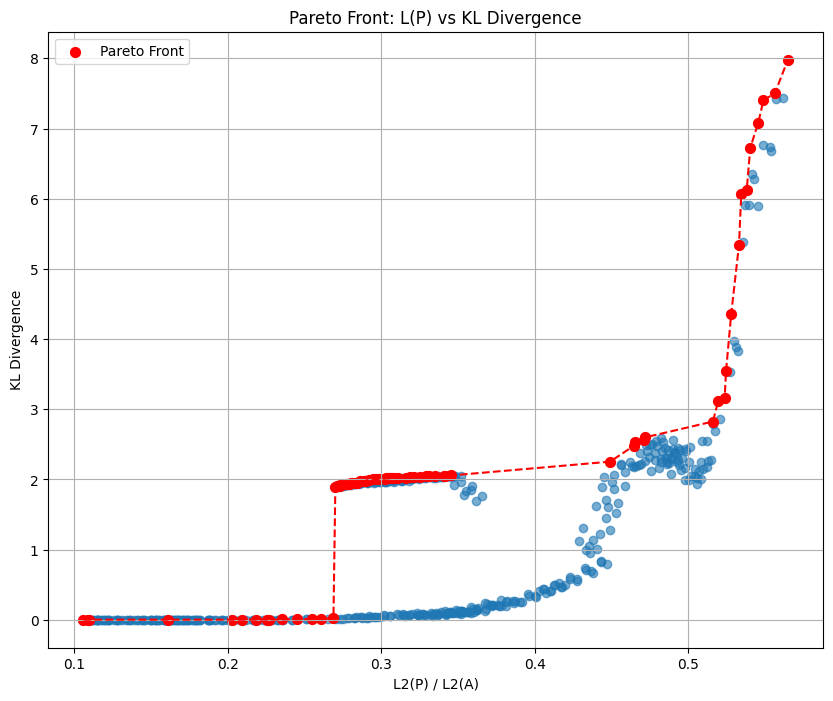

In [86]:
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient


# Assuming you have your data in lists or numpy arrays
lp_values = abl_df["L2(P) / L2(A)"]  # Your L(P) values
kl_div_values = abl_df.kl_div  # Your KL divergence values

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(lp_values, kl_div_values, alpha=0.6)

# Identify Pareto optimal points
costs = np.column_stack((lp_values, -kl_div_values))
pareto_points = is_pareto_efficient(costs)

# Highlight Pareto front
plt.scatter(
    lp_values[pareto_points],
    kl_div_values[pareto_points],
    color="red",
    s=50,
    label="Pareto Front",
)

# Connect Pareto front points
pareto_front = np.column_stack((lp_values[pareto_points], kl_div_values[pareto_points]))
pareto_front = pareto_front[pareto_front[:, 0].argsort()]
plt.plot(pareto_front[:, 0], pareto_front[:, 1], "r--")

# Set labels and title
plt.xlabel("L2(P) / L2(A)")
plt.ylabel("KL Divergence")
plt.title("Pareto Front: L(P) vs KL Divergence")

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## Feature Interaction Analysis
Ablate pairs of features and compare to individual ablations.

In [129]:
def compute_kl_div_single(model, base_ref, sae, f1):
    base_act = base_ref.act.squeeze()
    feature_acts = sae.encode(base_act)
    logits_base, _ = model.run_with_cache(base_ref.prompt)
    logprobs_base = F.log_softmax(logits_base[:, -1, :], dim=-1)

    feature_acts[f1] = 0
    perturbed_act = sae.decode(feature_acts)

    def hook(act, hook):
        act[:, -1, :] = perturbed_act

    with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
        logits_pert, _ = model.run_with_cache(base_ref.prompt)
        logprobs_pert = F.log_softmax(logits_pert[:, -1, :], dim=-1)

    kl_div = F.kl_div(
        logprobs_pert, logprobs_base, log_target=True, reduction="batchmean"
    )
    return kl_div.item()


def compute_kl_div_pair(model, base_ref, sae, f1, f2):
    base_act = base_ref.act.squeeze()
    feature_acts = sae.encode(base_act)
    logits_base, _ = model.run_with_cache(base_ref.prompt)
    logprobs_base = F.log_softmax(logits_base[:, -1, :], dim=-1)

    feature_acts[np.array([f1, f2])] = 0
    perturbed_act = sae.decode(feature_acts)

    def hook(act, hook):
        act[:, -1, :] = perturbed_act

    with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
        logits_pert, _ = model.run_with_cache(base_ref.prompt)
        logprobs_pert = F.log_softmax(logits_pert[:, -1, :], dim=-1)

    kl_div = F.kl_div(
        logprobs_pert, logprobs_base, log_target=True, reduction="batchmean"
    )
    return kl_div.item()


def analyze_feature_interactions(model, base_ref, sae, feature_order, num_features=5):
    interactions = {}
    for i, f1 in enumerate(feature_order[:num_features]):
        for f2 in feature_order[i + 1 : num_features + 1]:
            individual_effect = compute_kl_div_single(
                model, base_ref, sae, f1
            ) + compute_kl_div_single(model, base_ref, sae, f2)
            paired_effect = compute_kl_div_pair(model, base_ref, sae, f1, f2)
            interactions[(f1.item(), f2.item())] = paired_effect - individual_effect
    return interactions

In [130]:
base_act = base_ref.act.squeeze()
original_feature_acts = sae.encode(base_act)
non_negative_features = (original_feature_acts > 0).nonzero().squeeze()
sorted_feature_order = non_negative_features[
    torch.argsort(feature_acts[non_negative_features], descending=True)
]

interactions = analyze_feature_interactions(
    model, base_ref, sae, sorted_feature_order, num_features=20
)

# Get unique features from the interactions
features = sorted(set(f for pair in interactions.keys() for f in pair))
n_features = len(features)
feature_to_index = {f: i for i, f in enumerate(features)}
interaction_matrix = np.zeros((n_features, n_features))

# Fill the matrix with interaction values
for (f1, f2), value in interactions.items():
    i, j = feature_to_index[f1], feature_to_index[f2]
    interaction_matrix[i, j] = value
    interaction_matrix[j, i] = value  # Assuming symmetry in interactions

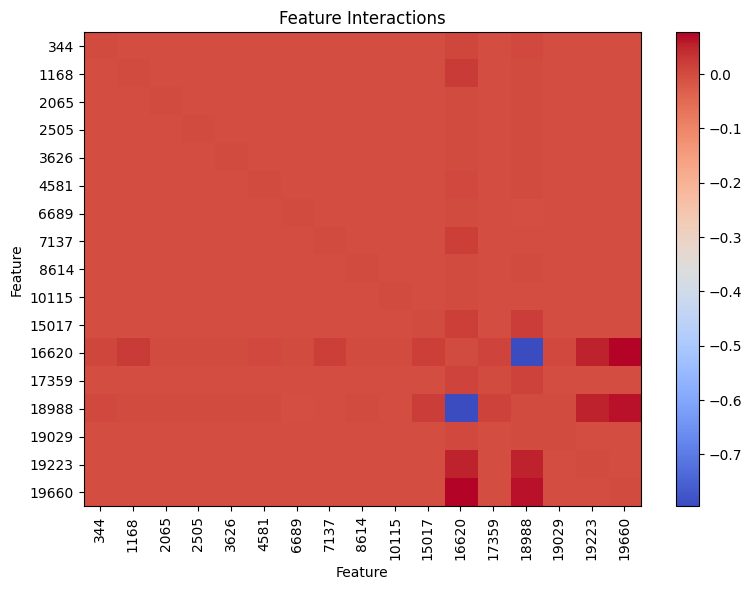

In [131]:
# Plot the interaction matrix
plt.figure(figsize=(8, 6))
im = plt.imshow(interaction_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar(im)

# Set tick labels to actual feature numbers
plt.xticks(range(n_features), features, rotation=90)
plt.yticks(range(n_features), features)

plt.title("Feature Interactions")
plt.xlabel("Feature")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

## Finding Neuronpedia interpretations for features

In [172]:
import requests
from typing import Optional


def get_explanation(
    layer, feature, model_name="gpt2-small", sae_name="res-jb"
) -> Optional[str]:
    """Fetches a single explanation for a given layer and feature from Neuronpedia."""
    res = requests.get(
        f"https://www.neuronpedia.org/api/feature/{model_name}/{layer}-{sae_name}/{feature}"
    ).json()
    explanation = (
        res["explanations"][0]["description"] if len(res["explanations"]) > 0 else None
    )

    return explanation

In [171]:
feature_explanations = {}

for f_id in active_features_with_acts:
    feature_explanations[f_id] = get_explanation(1, f_id)

In [209]:
feature_explanations

{18988: 'specific verbs in the past tense',
 16620: 'instances where the verb "were" is used',
 19223: 'web platform names and technological jargon',
 19660: 'words related to quotations or phrases emphasized in quotes',
 15017: 'places',
 17359: 'phrases related to taking control or responsibility',
 1168: 'written accounts related to criminal activities, emergencies, and law enforcement',
 6689: 'descriptions related to locations or settings, particularly where events are taking place',
 344: 'statements or phrases indicating disagreement or conflicting opinions',
 7137: 'the verb "are" in statements describing various situations',
 4581: 'names of cities',
 19029: 'expressions related to time, specifically focusing on durations',
 2065: 'phrases relating to noticing and attention',
 8614: 'phrases related to legal, political, and technical terms',
 2505: 'words related to legal actions and conflicts',
 3626: 'words associated with technology, such as code, script, and email',
 10115

### Zooming in 🔎

In [274]:
perturb_name = "controlled other activation"

kl_scores = results[perturb_name][0]
x = np.arange(len(kl_scores))
slopes = (np.diff(kl_scores) / np.diff(x)).tolist() + [0]

mean_slope = np.mean(slopes)
std_slope = np.std(slopes)
blowup_indices = np.where(slopes > mean_slope + 1 * std_slope)[0]

In [281]:
steps_info = []

for i, step_act in enumerate(results_step_activations[perturb_name][0]):
    is_part_of_blowup = i in blowup_indices
    print(
        f"Step: {i + 1} [KL = {kl_scores[i]:.4f}] [slope={slopes[i]:.2f}, blowup={is_part_of_blowup}]"
    )
    feature_acts = sae.encode(step_act)
    active_feature_ids = [
        f_id.item() for f_id in (feature_acts > 0).nonzero().squeeze()
    ]
    active_features_with_acts = sorted(
        zip(active_feature_ids, feature_acts[active_feature_ids]),
        key=lambda t: t[1],
        reverse=True,
    )
    print("\nActive Features:")

    feats = []
    for j, (f_id, f_act) in enumerate(active_features_with_acts[:5]):
        if feature_explanations.get(f_id) is None:
            feature_explanations[f_id] = get_explanation(1, f_id)
        print(f"  {j + 1}. {f_id} @{f_act:.2f} ({feature_explanations[f_id]})")
        feats.append((f_id, f_act.item(), feature_explanations[f_id]))

    steps_info.append(
        {
            "step": i + 1,
            "kl": kl_scores[i].item(),
            "slope": slopes[i],
            "blowup": is_part_of_blowup,
            "features": feats,
        }
    )
    print()

Step: 1 [KL = 0.0000] [slope=0.00, blowup=False]

Active Features:
  1. 18988 @13.69 (specific verbs in the past tense)
  2. 16620 @13.65 (instances where the verb "were" is used)
  3. 19223 @4.63 (web platform names and technological jargon)
  4. 19660 @4.00 (words related to quotations or phrases emphasized in quotes)
  5. 15017 @1.85 (places)

Step: 2 [KL = 0.0001] [slope=0.00, blowup=False]

Active Features:
  1. 18988 @14.02 (specific verbs in the past tense)
  2. 16620 @13.05 (instances where the verb "were" is used)
  3. 19223 @4.43 (web platform names and technological jargon)
  4. 19660 @3.84 (words related to quotations or phrases emphasized in quotes)
  5. 15017 @1.82 (places)

Step: 3 [KL = 0.0005] [slope=0.00, blowup=False]

Active Features:
  1. 18988 @14.35 (specific verbs in the past tense)
  2. 16620 @12.45 (instances where the verb "were" is used)
  3. 19223 @4.22 (web platform names and technological jargon)
  4. 19660 @3.68 (words related to quotations or phrases em

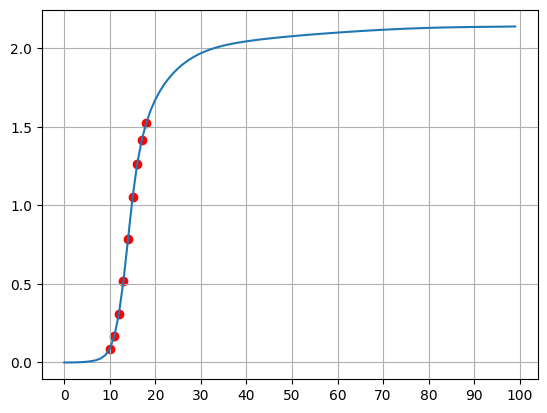

In [282]:
plt.plot(range(cfg.n_steps), kl_scores)
plt.scatter(blowup_indices, kl_scores[blowup_indices], color="red")
plt.grid(True)
plt.gca().set_xticks(np.arange(0, 101, 10))
plt.show()

In [293]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def split_description(desc, max_line_length=30):
    words = desc.split()
    lines = []
    current_line = []
    current_length = 0
    for word in words:
        if current_length + len(word) > max_line_length and current_line:
            lines.append(" ".join(current_line))
            current_line = [word]
            current_length = len(word)
        else:
            current_line.append(word)
            current_length += len(word) + 1
    if current_line:
        lines.append(" ".join(current_line))
    return "<br>".join(lines)


# Assuming your data is in this format
data = steps_info

# Prepare data
steps = [step["step"] for step in data]
kl_values = [step["kl"] for step in data]
slopes = [step["slope"] for step in data]
blowups = [step["blowup"] for step in data]

# Create figure
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=("Top 5 Active Features", "KL Divergence"),
    row_heights=[0.7, 0.3],
)

# Create initial empty bar plot
initial_bar = go.Bar(
    x=["Feature " + str(i + 1) for i in range(5)],
    y=[0] * 5,
    text=["" for _ in range(5)],
    textposition="outside",
    hoverinfo="text",
    showlegend=False,
)

# Create initial empty line plot for KL divergence
initial_line = go.Scatter(
    x=[steps[0]],
    y=[kl_values[0]],
    mode="lines+markers",
    name="KL Divergence",
    showlegend=False,
)

fig.add_trace(initial_bar, row=1, col=1)
fig.add_trace(initial_line, row=2, col=1)

# Update layout
fig.update_layout(
    title="Feature Activation and KL Divergence Over Steps",
    xaxis_title="Features",
    yaxis_title="Activation Strength",
    xaxis2_title="Step",
    yaxis2_title="KL Divergence",
    height=800,
    updatemenus=[
        dict(
            type="buttons",
            buttons=[
                dict(
                    label="Play",
                    method="animate",
                    args=[
                        None,
                        {
                            "frame": {"duration": 500, "redraw": True},
                            "fromcurrent": True,
                            "transition": {"duration": 0},
                        },
                    ],
                ),
                dict(
                    label="Pause",
                    method="animate",
                    args=[
                        [None],
                        {
                            "frame": {"duration": 0, "redraw": False},
                            "mode": "immediate",
                            "transition": {"duration": 0},
                        },
                    ],
                ),
                dict(
                    label="Reset",
                    method="animate",
                    args=[
                        ["frame0"],
                        {
                            "frame": {"duration": 0, "redraw": True},
                            "mode": "immediate",
                            "transition": {"duration": 0},
                        },
                    ],
                ),
            ],
            direction="left",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.98,
            xanchor="right",
            y=1.15,
            yanchor="top",
        )
    ],
)

# Create frames for animation
frames = []
for i, step_data in enumerate(data):
    feature_ids = [f[0] for f in step_data["features"]]
    feature_strengths = [f[1] for f in step_data["features"]]
    feature_descriptions = [f[2] for f in step_data["features"]]

    hover_texts = [
        f"ID: {id}<br>Strength: {strength:.2f}<br>Description: {desc}"
        for id, strength, desc in zip(
            feature_ids, feature_strengths, feature_descriptions
        )
    ]

    frame = go.Frame(
        data=[
            go.Bar(
                x=["Feature " + str(i + 1) for i in range(5)],
                y=feature_strengths,
                text=[
                    f"{id}<br>{split_description(desc)}"
                    for id, desc in zip(feature_ids, feature_descriptions)
                ],
                textposition="outside",
                textangle=0,
                hovertext=hover_texts,
                hoverinfo="text",
                showlegend=False,
            ),
            go.Scatter(
                x=steps[: i + 1],
                y=kl_values[: i + 1],
                mode="lines+markers",
                name="KL Divergence",
                showlegend=False,
            ),
        ],
        layout=go.Layout(
            title_text=f"Step: {step_data['step']}, KL: {step_data['kl']:.4f}, Slope: {step_data['slope']:.2f}, Blowup: {'Yes' if step_data['blowup'] else 'No'}"
        ),
        name=f"frame{i}",
    )
    frames.append(frame)

fig.frames = frames

# Update axes
fig.update_xaxes(tickangle=45, row=1, col=1)
fig.update_yaxes(
    range=[0, max([max(f[1] for f in step["features"]) for step in data]) * 1.1],
    row=1,
    col=1,
)
fig.update_xaxes(range=[0, len(steps)], row=2, col=1)
fig.update_yaxes(range=[0, max(kl_values) * 1.1], row=2, col=1)

# Show the figure
fig.show()